### 训练模型

In [1]:
# 准备工作， 去前面一样
import numpy as np
import pandas as pd
import os

np.random.seed(42)

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


### 线性回归

关于线性回归参数的求解，可以使用标准方程，直接得到参数最优解。

$$\widehat{\theta}  = (X^{T} \cdot X)^{-1}\cdot X^{T}\cdot y$$    
使用https://www.codecogs.com/latex/eqneditor.php 编辑

In [202]:
X = 2 * np.random.rand(100, 1) #产生100 * 1的范围在0--1内的随机数。
y = 4 + 3 * X + np.random.rand(100, 1)

假设要求X，Y线性回归的参数，除去噪声的影响，参数为(3, 4)

Saving figure generated_data_plot


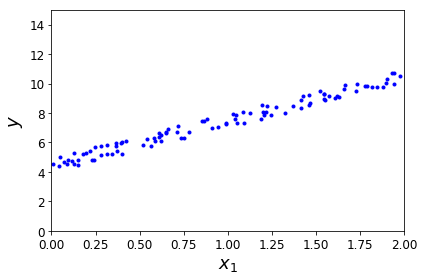

In [203]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize = 18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [204]:
# 因为有常数项的缘故， 因此添加常数的参数为1.
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [205]:
theta_best # 可以看得结果，常数项为4左右，参数为3左右

array([[4.51359766],
       [2.98323418]])

In [206]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  #添加常数项 1
y_predict = X_new_b.dot(theta_best)
y_predict 

array([[ 4.51359766],
       [10.48006601]])

Saving figure linear_model_predictions


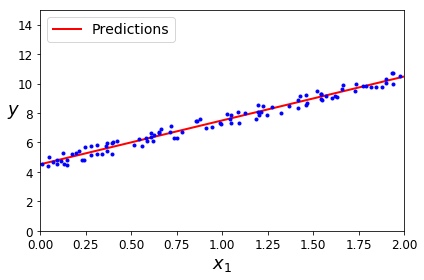

In [207]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0,  fontsize = 18)
plt.legend(loc="upper left", fontsize=14) #加上图例
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions")
plt.show()

下面使用sklearn的线性回顾模型来做预测对比

In [208]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.51359766]), array([[2.98323418]]))

可以看到结果是一样的。LinearRegression 也是基于scipy.linalg.lstsq()， 因此也可以这样求解。

In [209]:
theta_best_svd, residutals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.51359766],
       [2.98323418]])

In [210]:
np.linalg.pinv(X_b).dot(y)

array([[4.51359766],
       [2.98323418]])

不过由于计算的复杂度过高，因此在特征较大时，一般都不使用方程求解。

### 使用梯度下降求解线性回归

对于线性回归来说，需要计算损失函数的偏导数。  
然后对  ${\theta}$ 做更新。   
这里不做公式推导和介绍。

In [211]:
eta = 0.1 # 学习速率
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1) #随机初始化

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [212]:
theta

array([[4.51359766],
       [2.98323418]])

In [213]:
X_new_b.dot(theta)

array([[ 4.51359766],
       [10.48006601]])

In [214]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title("$\eta={}$".format(eta), fontsize=16)


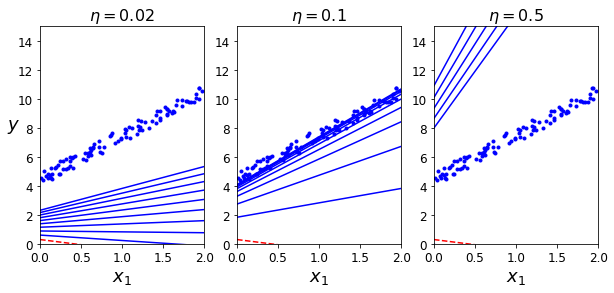

In [215]:
theta = np.random.randn(2, 1)  #随机初始化

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); 
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); 
plot_gradient_descent(theta, eta=0.5)

可以看到不同的学习率对结果的影响，过小拟合过程会很慢，过大容易过拟合。  
为了寻找合适的学习率，可以使用网格搜索。  
另外一个参数是循环次数，这里可以采用当误差小于某一个值时， 结束循环。

### 随机梯度下降

上述的梯度下降最大的问题在于每次都是用全部数据集进行计算，因此计算速度很慢。而随机梯度下降每次随机选择一个实例计算梯度进行更新。  
很显然可以加快运行速度，因此可以训练很大的数据集。  因此SGD可以算是out-of-core算法。
另外一个问题，由于随机性，下降方向不是沿着梯度(上下起伏)，而是曲折的降低，直到最小值。  
到最小值之后会继续反弹，永远不会稳定。所以一旦算法停止，最终的参数不一定是最优解。  

当损失函数不是特别规范时， 即有多个局部最优解， 随机梯度下降可以跳出局部最优解，因此有更好的机会求得全局最优解。  
由于这种特性，到达最优解是也不会停止计算。一种解决方式是逐渐减小学习率。这个过程叫做退火(simulated annealing)。  

In [216]:
theta_path_sgd = []
m = len(X_b)

Saving figure sdd_plot


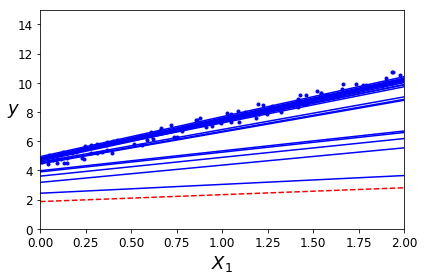

In [217]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        
plt.plot(X, y, "b.")
plt.xlabel("$X_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sdd_plot")
plt.show()

In [218]:
theta

array([[4.51851544],
       [2.98246311]])

In [219]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1,random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [220]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.51388816]), array([2.98206789]))

### 小批量梯度下降

基于之前的两种梯度下降，mini bathc梯度下降就是每一步随机选择一部分数据计算。  
优点都是可以从硬件矩阵操作的性能上得到提升，尤其是在使用GPU时。

In [221]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)  #满足标准正态分布的随机值  2 * 1 维度

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i + minibatch_size]
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
    

In [222]:
theta

array([[4.47970445],
       [3.01436055]])

In [223]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


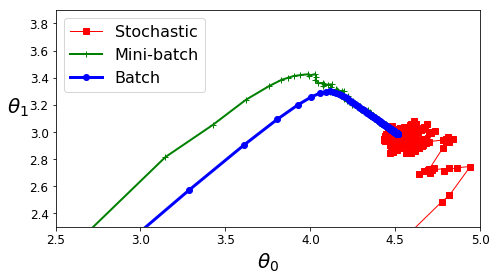

In [224]:
plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 5.0, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

### 多项式回归

假如数据比较复杂，不是一条直线。当然也可以用直线去拟合，简单的方式就是把每个属性的高次幂当做一个新的特征。  
这称之为多项式回归。

In [226]:
m = 100
X = 6 * np.random.rand(m ,1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.rand(m, 1)

Saving figure quadratic_data_plot


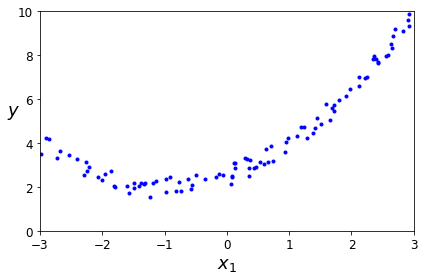

In [227]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

可以使用如下方法进行线性拟合：

In [228]:
from sklearn.preprocessing import PolynomialFeatures
ploy_features = PolynomialFeatures(degree=2, include_bias=False)
X_ploy = ploy_features.fit_transform(X)
X[0]

array([2.38942838])

In [229]:
X_ploy[0]

array([2.38942838, 5.709368  ])

In [230]:
lin_reg = LinearRegression()
lin_reg.fit(X_ploy, y)
lin_reg.intercept_ , lin_reg.coef_

(array([2.5278938]), array([[0.9804785 , 0.49468385]]))

可以看到得到的结果与之前给出的参数是大致相同的。

Saving figure quadratic_predictions_plot


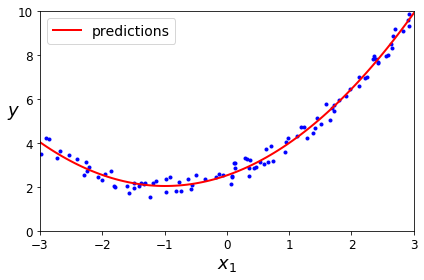

In [231]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = ploy_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

In [238]:
#### 学习曲线

Saving figure high_degree_polynomials_plot


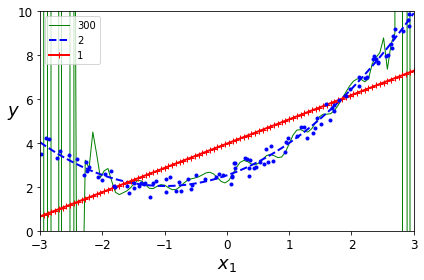

In [232]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

    
plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

上图演示了用不同的多项式去拟合数据。可以看到高次多项式回归模型过拟合，而线性回归模型欠拟合。二次项最好。  
但是，一般情况下并不知道选择几次多项式回归模型，并且怎么知道是过拟合，还是欠拟合？

前面提到 可以使用交叉验证来估计模型的泛化能力。如果模型在训练集表现很好，但是交叉验证效果变差， 说明模型过拟合。  
如果都表现的很差， 说明模型欠拟合。  
另一种方式是看学习曲线: 随着训练集大小的增加去训练数据，画出图像，如下代码所示。

In [233]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)   

Saving figure underfitting_learing_curves_plot


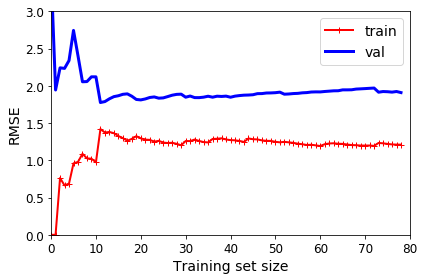

In [234]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learing_curves_plot")
plt.show()

上图是线性模型的学习曲线。首先看训练集的表现，当只有很少的实例时，完美匹配， 因此RMSE接近0， 随着数量的增加，越来越去拟合数据， 因为噪声的加入及其并不是线性的。因此错误不断增加，直到到达顶点。  
看验证集的曲线：当只有少量实例时， 不能很好的推广预测，因此错误较大。随着数据增多，误差较小，直到到达地点。  
两条曲线很接近。

这是明显的欠拟合，两条曲线接近但是误差很大。

Saving figure learning_curves_plot


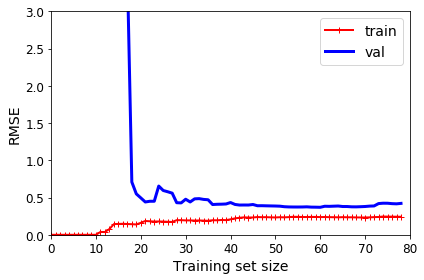

In [235]:
from sklearn.pipeline import Pipeline
## 10次项回归模型
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
save_fig("learning_curves_plot")
plt.show()

和前面的有一点像，不过有两点很重要的区别：  
1. 训练集得到的错误比线性模型的小很多
2. 曲线之间有明显的间隔。这说明模型在训练集的效果要比验证集要好很多， 明显过拟合。但是如果加入更多的数据，两条曲线会越来越接近。  

提高过拟合模型的一个方法是加入更多的训练数据，直到验证集误差接近测试集误差。

#### 偏差/方差权衡
统计和机器学习的一个重要理论结果是，模型的泛化误差可以表示为三个完全不同的错误之和：
* 偏差：由于错误假设产生，比如假设数据是线性的， 实际上是二次方的。高偏差说明模型可能欠拟合。
* 方差：由于模型对数据的微小变化过于敏感。具有许多自由度(高次项)的模型会有高方差，可能过拟合数据。
* 不可减少的错误：由于数据的噪声产生。唯一的方法就是清洗数据。比如检测，移除异常值。

### regularized model(正则化模型，限制模型)

之前有过介绍，防止过拟合的比较好的方法是正则化(限制), 让它有更少的自由度， 就难以过拟合数据。  
比如正则化多项式模型就是减少多项式的次数。 

而对于线性模型来说，则意味着约束模型的权重。有Ridge(脊回归)， lasso(拉索回归)和弹性网(Elastic net).

#### Ridge 回归 (Tikhonov 正则)

其损失函数为： $J(\theta)=MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^{n}\theta_{i}^{2}$  
在训练不止要训练数据，还要从保持w足够小，限制模型。一旦训练完成，就可以使用非正则化的性能度量来评估模型的性能

超参数$\alpha$ 控制正则化模型的程度。比如为0时，此时就是线性回归。  
很大时，所有的w变得很小， 接近0， 结果就是一条平行x的直线。

注意：从函数来看， 偏置项$\theta_0$ 没有被正则化，从i=1开始。如果w向量是特征权重($\theta_0 -> \theta_n$),正则项简单等于 $\frac{1}{2}(\left \| w \right \|_{2})^{^{2}}$。这表示权重向量的l2规范。  
对于梯度下降，知只是添加$\alpha w$ 到梯度向量

需要注意一点，对于ridge回归来说， 缩放数据非常重要。对于输入特征的缩放非常敏感。  
大多数正则模型都是这样。

In [8]:


from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("regul_reg", model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
        
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

Saving figure ridge_regression_plot


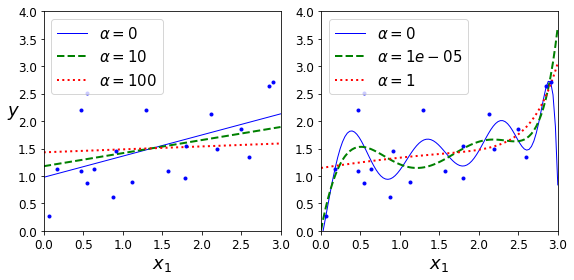

In [250]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [251]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [257]:
sgd_reg = SGDRegressor(max_iter=5, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.13500145])

惩罚(penalty)超参数是所使用正则化项的类型，比如l2。 指定l2 意味着将添加l2正则化项给SGD的损失函数。

In [258]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

### Lasso Regression

最小绝对收缩和选择算子回归(简称Lasso回归)是线性回归的另一种方式：像脊回归一样，也是向损失函数添加一个正则项。  
但添加的l1正则项：$J(\theta)=MSE(\theta) + \alpha \sum_{i=1}^{n}\left \| \theta_i \right \|$  
而不是l2正则项。

Saving figure lasso_regression_plot


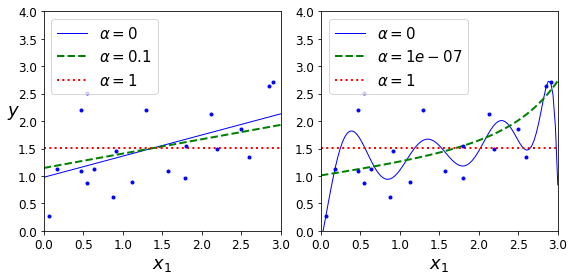

In [259]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)


save_fig("lasso_regression_plot")
plt.show()

拉索回去倾向于完全消除最不重要权重的特征(使其为0)。  
比如右边图片中($\alpha = 10^{-7}$) 看起来像二次项，但接近于线性：所有的高次项几乎等于0。 换句话说，Lasso回归自动执行特征选择，并输出一个稀疏模型(即:，带有极少的非零特征权重)。

In [11]:


from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### 弹性网络


In [265]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 提前停止

梯度下降循环中，验证错误到达某一个最小值时， 停止循环。  
下图显示一个复杂的模型进行梯度下降。随着迭代的进行，预测误差RMSE 逐渐降低。然而过了某个值后会升高， 此时意味着模型可能过拟合了。   
提前停止也是一种有效的限制技术。

Saving figure early_stopping_plot


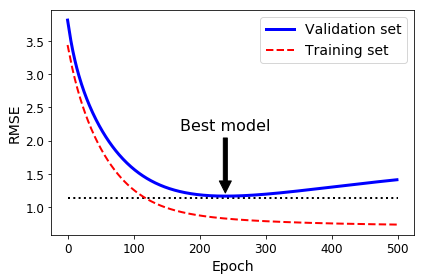

In [285]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )
best_val_rmse -= 0.03
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [286]:
from sklearn.base import clone 
sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [287]:
best_epoch, best_model

(239, SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', max_iter=1, n_iter=None, penalty=None,
        power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
        warm_start=True))

In [294]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


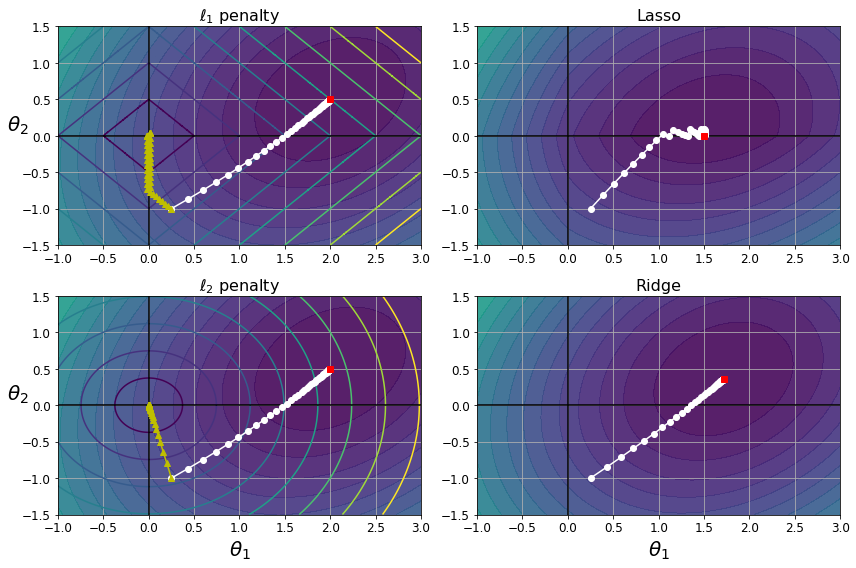

In [295]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()

### 逻辑回归